## Satellite Tracking
The recent privatization of space flight have led to the launch of thousands of artificial satellites. These satellites emit electromagnetic radiation across a wide variety of broad- and narrowband frequencies from both intentional and unintentional emissions ([Di Vruno et al. 2023](https://www.aanda.org/articles/aa/pdf/forth/aa46374-23.pdf)). These are begining to negatively impact all ground-based observing through tracks being left in optical images and false signals appearing in radio data.

In an attempt to keep track of satellite emissions, we are going to allocate 4 dishes at the Allen Telescope Array to collect emission data from the regions of the sky which are hte most affected. This will hopefully lead to an exhaustive list of frequencies and locations for all satellites in orbit.

The first step of this is to create a plot with the location of all active satellites in the sky above Hat Creek, the location of the Allen Telescope Array, throughout the course of one day. 

In [1]:
#Import everything you need
import numpy as np
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook 
from matplotlib.colors import LinearSegmentedColormap
from skyfield import almanac
from skyfield.api import load, wgs84
from skyfield.magnitudelib import planetary_magnitude
from skyfield.api import EarthSatellite
from astropy.coordinates import EarthLocation,SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import AltAz
import matplotlib
#Makes plots interactive
%autosave 30 
#Makes it to where it autosaves every minute instead of every 2 minutes, just for peace of mind

Autosaving every 30 seconds


In [2]:
#Use skyfield to import the TLE (two-line element) file [gives you all the information on a satellite's location at 
#the epoch, which can be used to find its location at any time] for all active satellites on Norad
active_url = 'https://celestrak.org/norad/elements/active.txt'
active = load.tle_file(active_url, reload = True)
print('Loaded', len(active), 'satellites')

[#################################] 100% active.txt


Loaded 8364 satellites


In [3]:
ts = load.timescale()
t = []
for i in range(24):
    for j in range(0, 60, 10):
            t.append(ts.utc(ts.now().utc[0], ts.now().utc[1], ts.now().utc[2], i, j, 0))

In [4]:
observing_location= EarthLocation.of_site('ATA')#A different way to set our location
observing_time = []
for i in range(len(t)):
    observing_time.append(Time(t[i].utc_datetime()))
aa = AltAz(location=observing_location, obstime=observing_time)

In [5]:
ata = wgs84.latlon(+observing_location.lat.value, observing_location.lon.value)

In [6]:
names = []
for i in range(len(active)):
    names.append(active[i].name)

In [7]:
difference = []
for i in range(len(active)):
    difference.append(active[i] - ata)

In [8]:
topocentric = []
for i in range(len(difference)):
    for j in range(len(t)):
        topocentric.append(difference[i].at(t[j]))

In [9]:
%%time
#takes about 1 minute to run
alt = []
az = []
distance = []
for i in range(len(topocentric)):
    if np.isnan(topocentric[(i)].altaz()[0].degrees) == True:
        alt.append(0)
        az.append(0)
        distance.append(0)
    elif np.isnan(topocentric[(i)].altaz()[0].degrees) == False:
        alt.append(topocentric[i].altaz()[0].degrees)
        az.append(topocentric[i].altaz()[1].degrees)
        distance.append(topocentric[i].altaz()[2].au)

CPU times: user 1min 7s, sys: 999 ms, total: 1min 8s
Wall time: 1min 9s


In [10]:
alt = np.reshape(alt, (len(active), len(t)))
az = np.reshape(az, (len(active), len(t)))
distance = np.reshape(distance, (len(active), len(t)))

To create the plots which show the areas where the most satellites are located, I used a heatmap.

Code for the heatmaps from [here](https://matplotlib.org/stable/gallery/images_contours_and_fields/image_annotated_heatmap.html)

In [11]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw, shrink = 0.5)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")
    

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels, fontsize = 9)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels, fontsize = 9)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=80, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    #ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    plt.gca().invert_yaxis()

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)], fontsize = 9)
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

For these plots, we are going to be looking at the sky above the ATA sectioned up 4 different ways -- 9$\times$36 (a 10 degree fov), 18${\times}$72 (a 5 degree fov), 30$\times$120 (a 3 degree fov), and 90$\times$360 (a 1 degree fov). 

First, the 9$\times$36

In [12]:
%%time
qt = []
at = []
for i in range(len(alt)):
    #print(i) #uncomment this if you want to see where it is in its running
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 9):
                if (h*10) <= alt[i][j] < ((h+1)*10):
                    for k in range(0, 36):
                        if (k*10) <= az[i][j] < ((k+1)*10):
                            qt.append((h*36) + k + 1)
                            at.append((h*36) + k + 1)
        if alt[i][j] <= 0:
            qt.append(0)
            at.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 1.2 s, sys: 20.3 ms, total: 1.22 s
Wall time: 1.23 s


In [13]:
qt = np.reshape(qt, (len(active), len(t)))
at = np.reshape(at, (len(active), len(t)))

In [14]:
%%time
#I'm correcting for the geo satellites by setting 
for i in range(len(at)):
    for j in range(len(at[0])-1):
        if at[i][j] == at[i][j+1]:
            qt[i][j+1] = 0

CPU times: user 444 ms, sys: 5.05 ms, total: 449 ms
Wall time: 451 ms


In [15]:
qt = np.reshape(qt, (len(active) * len(t)))
at = np.reshape(at, (len(active) * len(t)))

In [16]:
%%time
s10fix = []
s10f2 = []
for i in range(len(qt)):
    s10fix.append(f's{qt[i]}')
for i in range(len(at)):
    s10f2.append(f's{at[i]}')


CPU times: user 484 ms, sys: 22.2 ms, total: 506 ms
Wall time: 509 ms


In [17]:
%%time
#which section the satellite is in
sections_10f = []
sections_10f2 = []
for i in range(1, 325):
    if s10fix.count(f's{i}') == 0:
        sections_10f.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s10fix.count(f's{i}') != 0:
        sections_10f.append(s10fix.count(f's{i}'))
        
for i in range(1, 325):
    if s10f2.count(f's{i}') == 0:
        sections_10f2.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s10f2.count(f's{i}') != 0:
        sections_10f2.append(s10f2.count(f's{i}'))

CPU times: user 15.7 s, sys: 157 ms, total: 15.9 s
Wall time: 15.9 s


In [18]:
%%time
alt_range10f = []
az_range10f = []

for i in range(0, 9):
    alt_range10f.append(f'{i*10} - {(i+1)*10}')
for i in range(0, 36):
    az_range10f.append(f'{i*10} - {(i + 1)*10}')

CPU times: user 10 µs, sys: 0 ns, total: 10 µs
Wall time: 12.2 µs


In [19]:
sections10f = np.reshape(sections_10f, (9, 36))
sections10f2 = np.reshape(sections_10f2, (9, 36))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


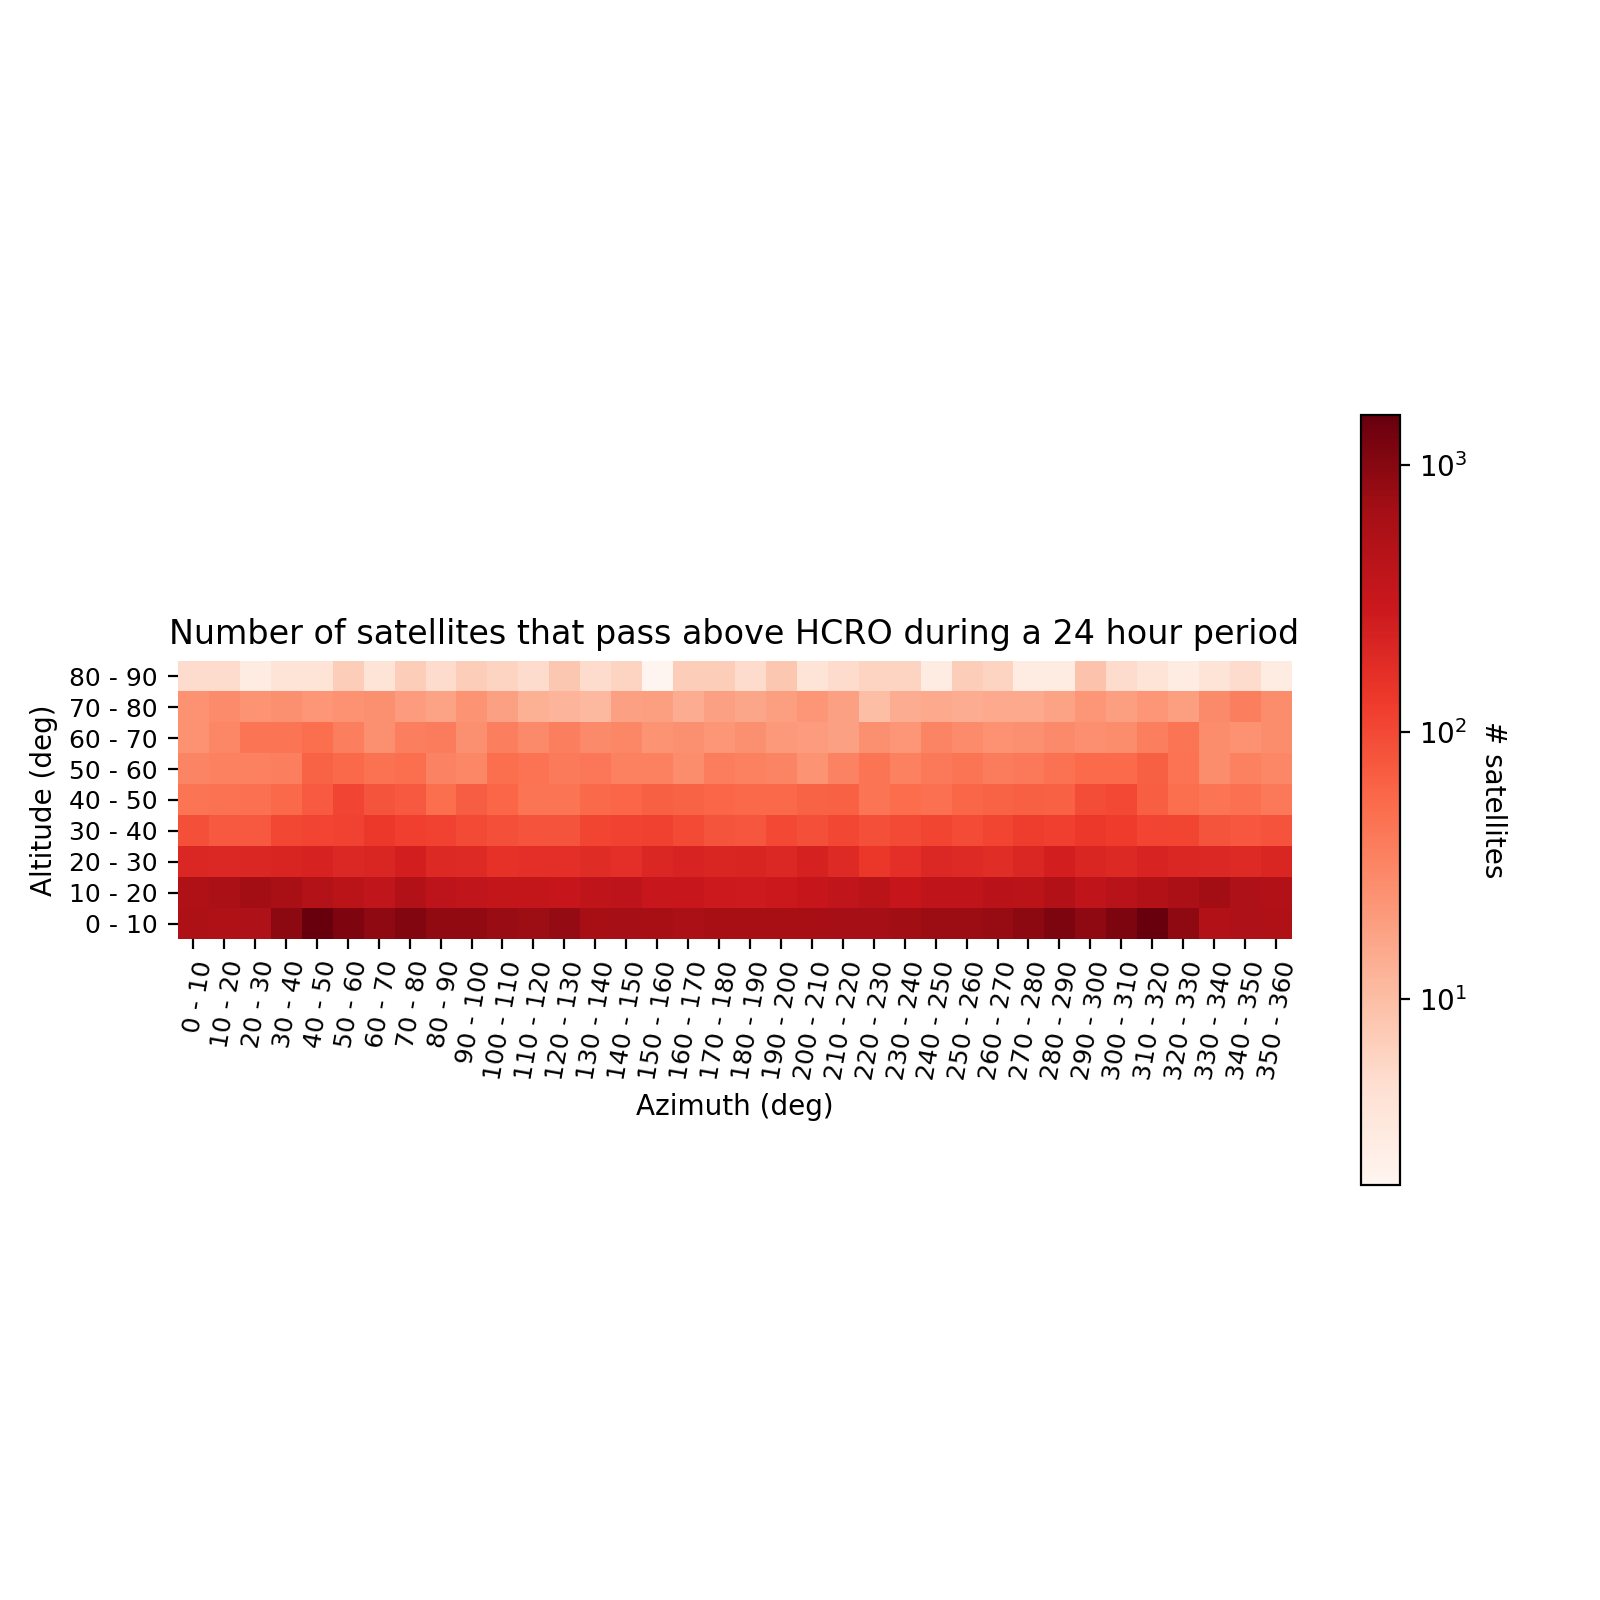

In [20]:
#With correcting for geo satellites
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections10f), alt_range10f, az_range10f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('10deg.jpeg')

<IPython.core.display.Javascript object>


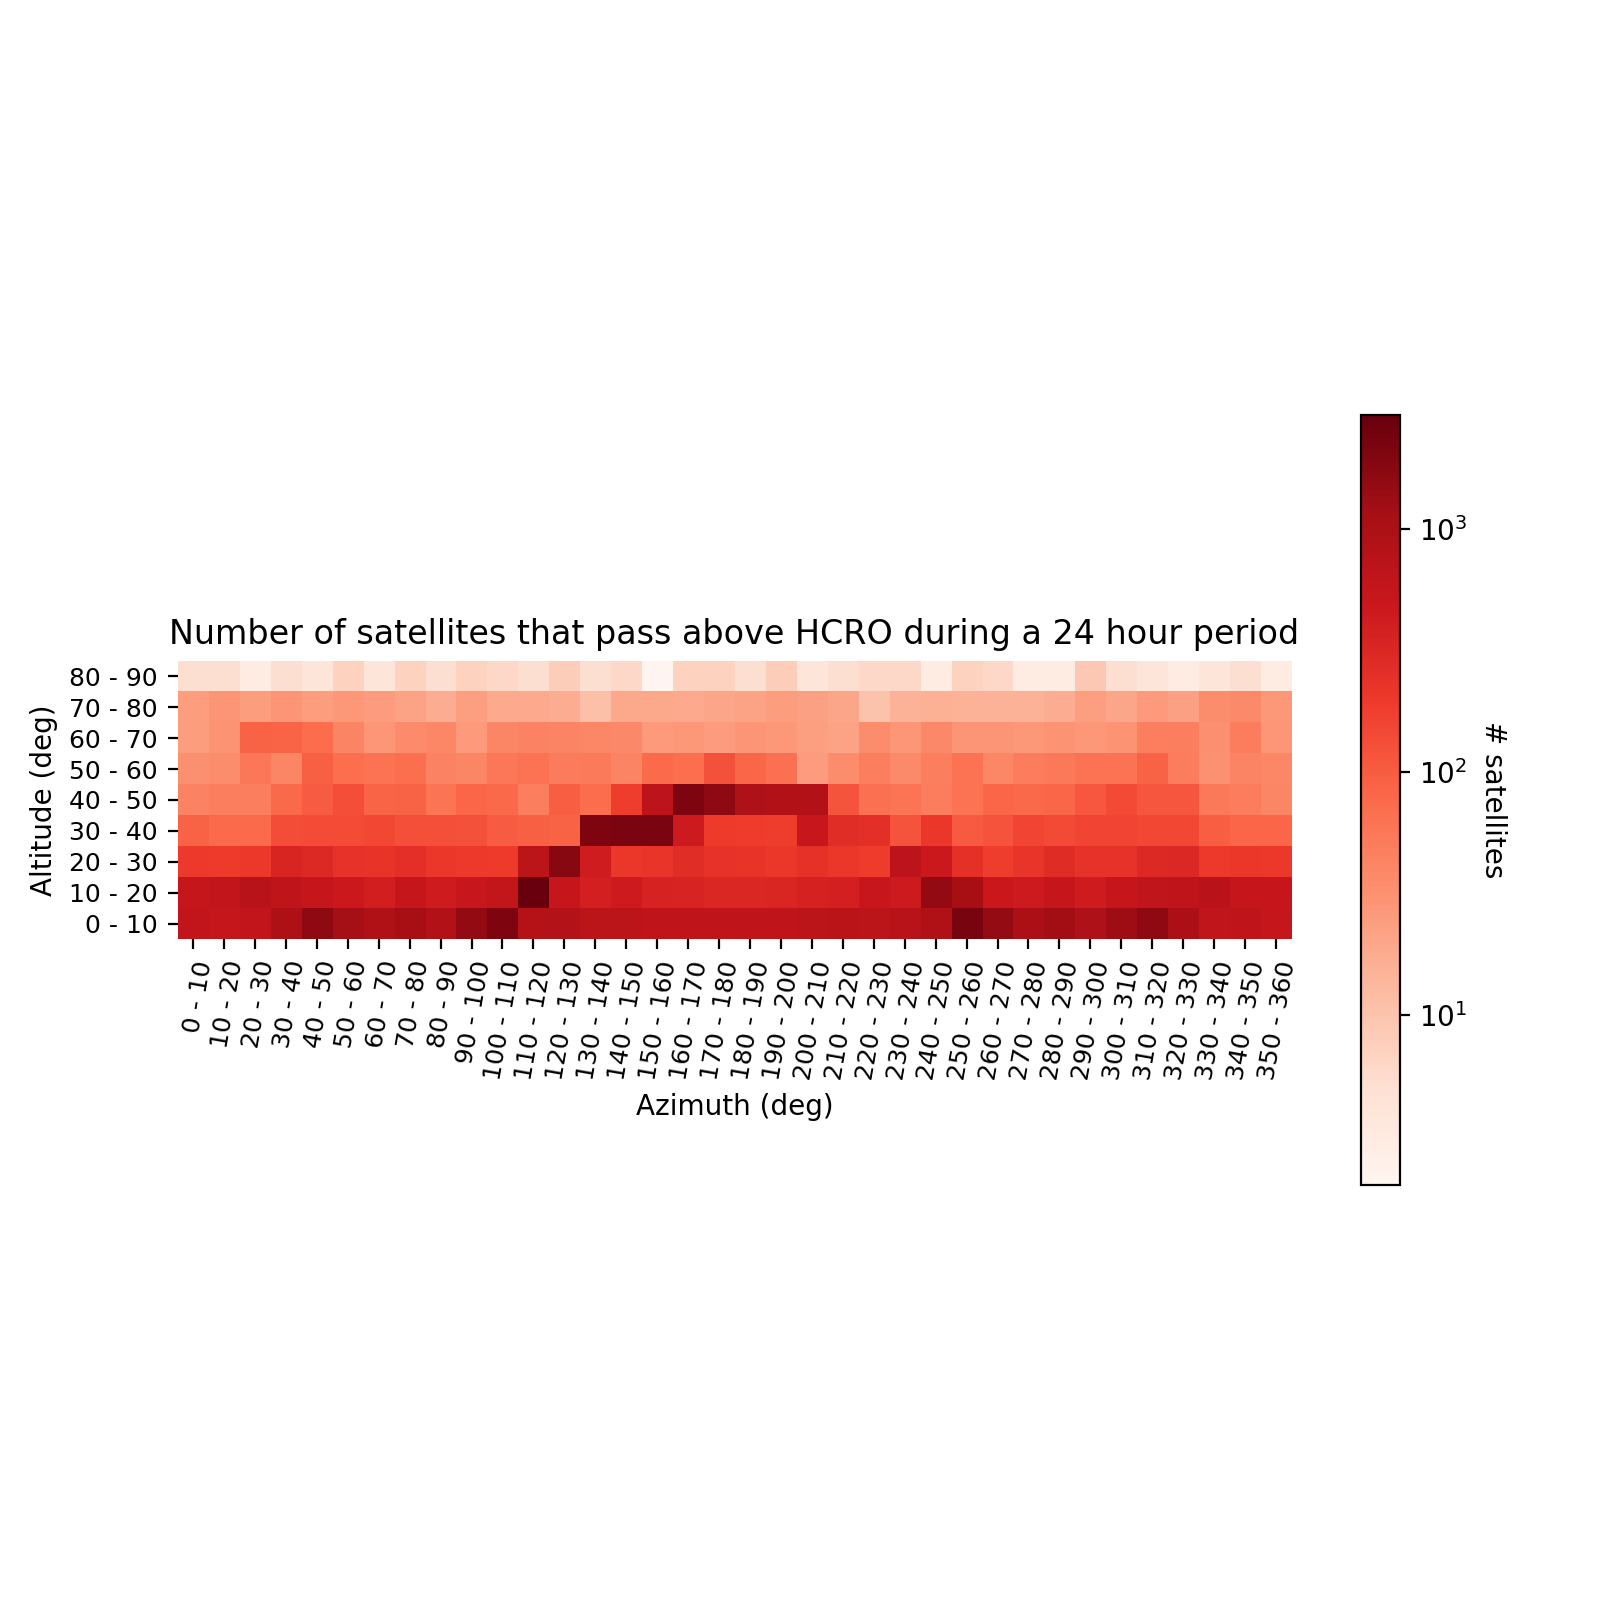

In [21]:
#Without correcting for geo satellites
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections10f2), alt_range10f, az_range10f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('10deg.jpeg')

And then for the $18 \times 72$ grid

In [22]:
%%time
qt5 = []
at5 = []
for i in range(len(alt)):
    #print(i)
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 18):
                if (h*5) <= alt[i][j] < ((h+1)*5):
                    for k in range(0, 72):
                        if (k*5) <= az[i][j] < ((k+1)*5):
                            qt5.append((h*72) + k + 1)
                            at5.append((h*72) + k + 1)
        if alt[i][j] <= 0:
            qt5.append(0)
            at5.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 2.5 s, sys: 38.3 ms, total: 2.54 s
Wall time: 2.1 s


In [23]:
qt5 = np.reshape(qt5, (len(active), len(t)))
at5 = np.reshape(at5, (len(active), len(t)))

In [24]:
for i in range(len(at5)):
    for j in range(len(at5[0])-1):
        if at5[i][j] == at5[i][j+1]:
            qt5[i][j+1] = 0

In [25]:
qt5 = np.reshape(qt5, (len(active) * len(t)))
at5 = np.reshape(at5, (len(active) * len(t)))

In [26]:
%%time
s5q = []
s5a = []
for i in range(len(qt5)):
    s5q.append(f's{qt5[i]}')
for i in range(len(at5)):
    s5a.append(f's{at5[i]}')


CPU times: user 452 ms, sys: 29.8 ms, total: 482 ms
Wall time: 485 ms


In [27]:
%%time
#takes about 1 minute
#which section the satellite is in
sections_5q = []
sections_5a = []
for i in range(1, 1297):
    if s5q.count(f's{i}') == 0:
        sections_5q.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s5q.count(f's{i}') != 0:
        sections_5q.append(s5q.count(f's{i}'))
        
for i in range(1, 1297):
    if s5a.count(f's{i}') == 0:
        sections_5a.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s5a.count(f's{i}') != 0:
        sections_5a.append(s5a.count(f's{i}'))

CPU times: user 1min 3s, sys: 795 ms, total: 1min 3s
Wall time: 1min 4s


In [28]:
%%time
alt_range5f = []
az_range5f = []

for i in range(0,18):
    alt_range5f.append(f'{i*5} - {(i+1)*5}')
for i in range(0, 72):
    az_range5f.append(f'{i*5} - {(i + 1)*5}')

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 19.8 µs


In [29]:
az_range5f_label = []
alt_range5f_label = []
azs5 = []
alts5 = []
for i in range(int(len(az_range5f)/2)):
    azs5.append((i*2)+1)
    az_range5f_label.append(az_range5f[azs5[-1]])
    
for i in range(int(len(alt_range5f)/2)):
    alts5.append((i*2)+1)
    alt_range5f_label.append(alt_range5f[alts5[-1]])

In [30]:
sections5a = np.reshape(sections_5a, (18, 72))
sections5q = np.reshape(sections_5q, (18, 72))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


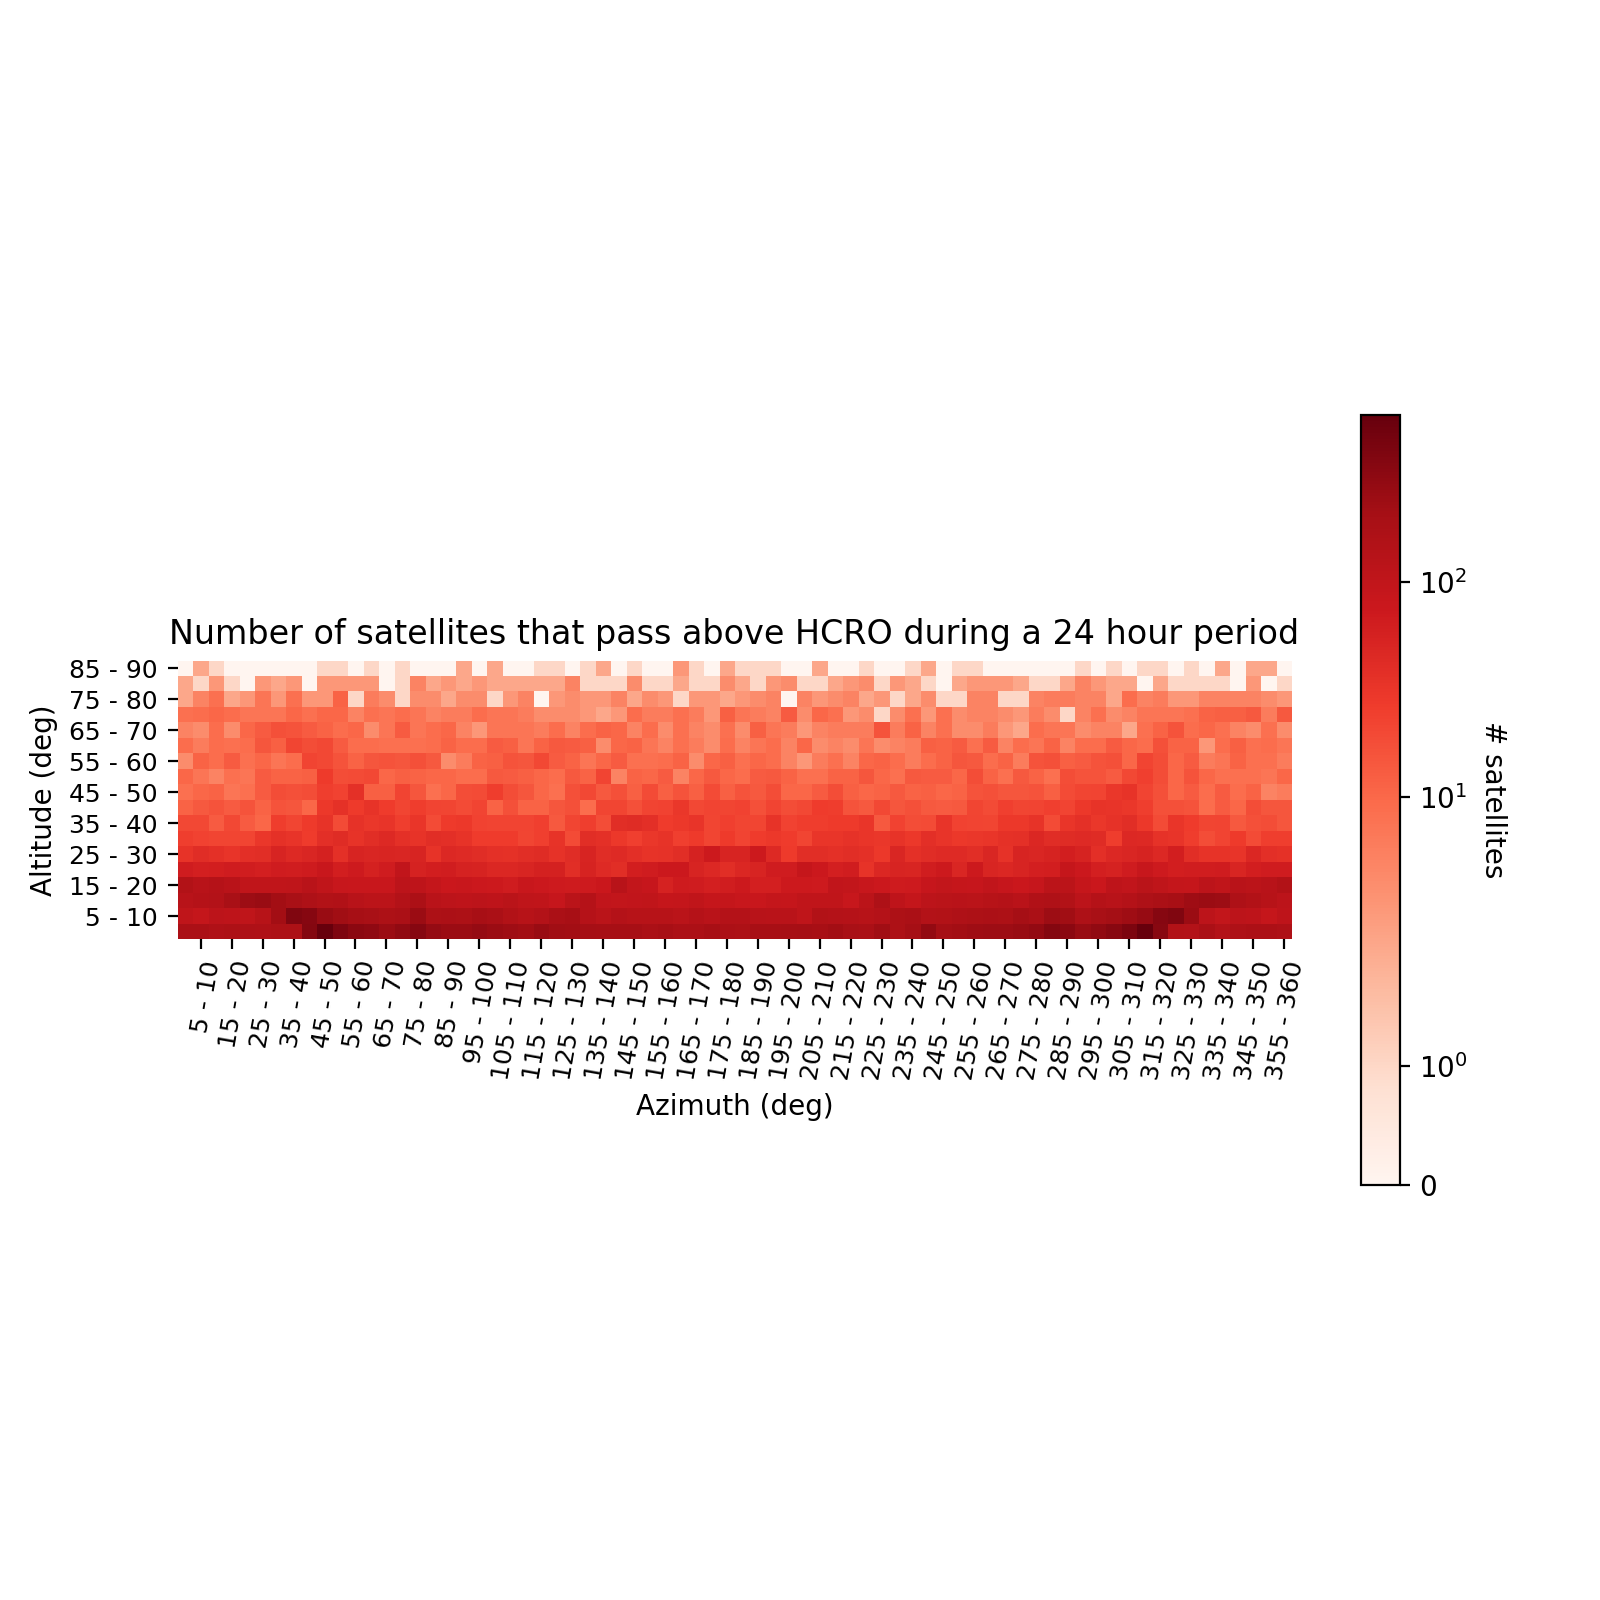

In [31]:
#with correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections5q), alt_range5f, az_range5f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs5, labels=az_range5f_label)
plt.yticks(ticks = alts5, labels = alt_range5f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
plt.savefig('5deg.jpeg')

<IPython.core.display.Javascript object>


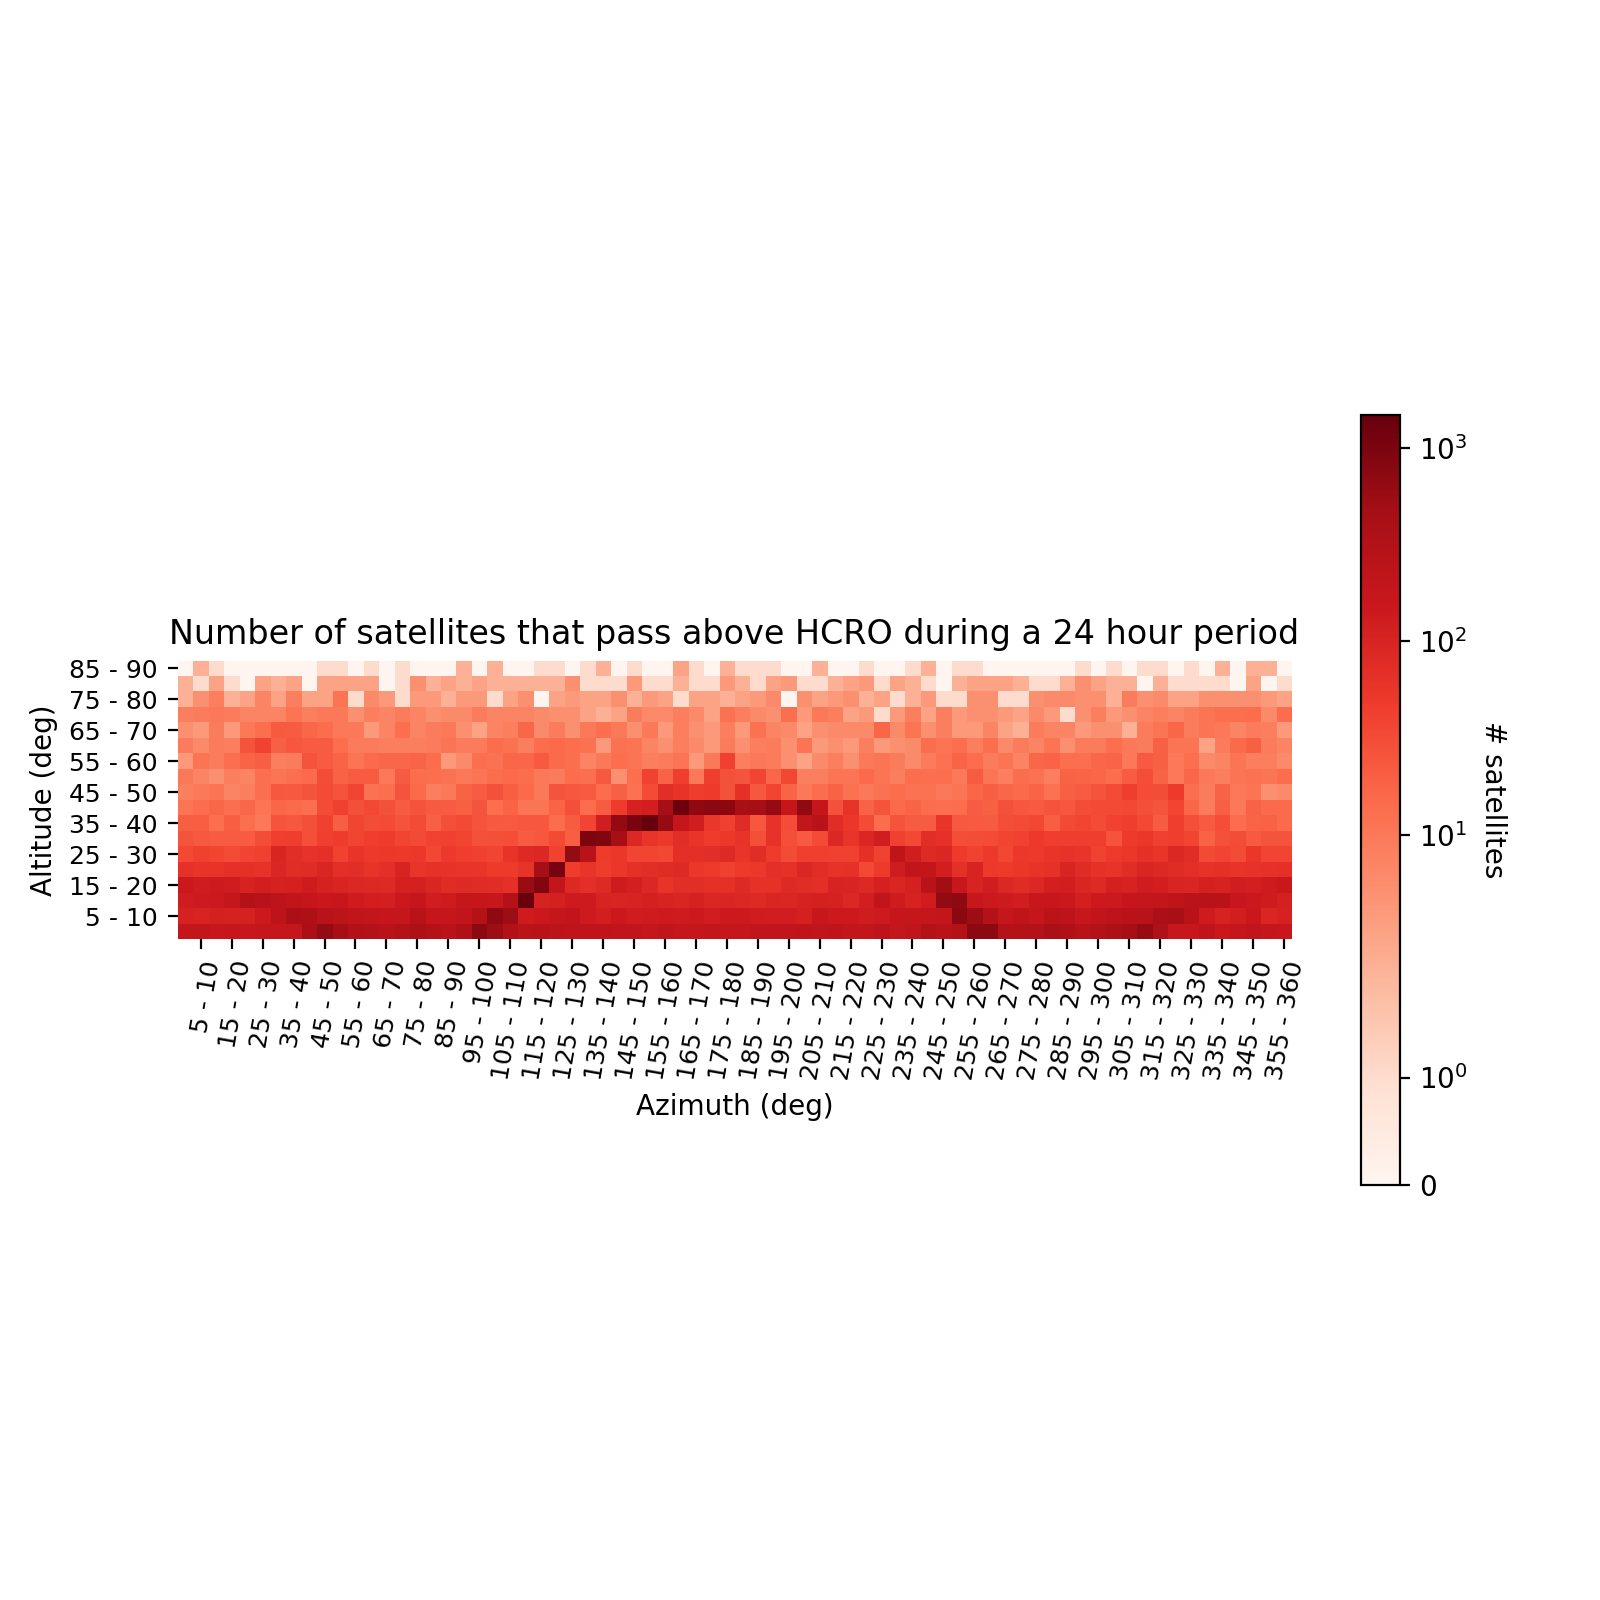

In [32]:
#Without correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections5a), alt_range5f, az_range5f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs5, labels=az_range5f_label)
plt.yticks(ticks = alts5, labels = alt_range5f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('5deg.jpeg')

And then for the $30 \times 120$ grid

In [35]:
%%time
qt3 = []
at3 = []
for i in range(len(alt)):
    #print(i)
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 30):
                if (h*3) <= alt[i][j] < ((h+1)*3):
                    for k in range(0, 120):
                        if (k*3) <= az[i][j] < ((k+1)*3):
                            qt3.append((h*120) + k + 1)
                            at3.append((h*120) + k + 1)
        if alt[i][j] <= 0:
            qt3.append(0)
            at3.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 3.37 s, sys: 54.9 ms, total: 3.42 s
Wall time: 3.02 s


In [36]:
qt3 = np.reshape(qt3, (len(active), len(t)))
at3 = np.reshape(at3, (len(active), len(t)))

In [37]:
for i in range(len(at3)):
    for j in range(len(at3[0])-1):
        if at3[i][j] == at3[i][j+1]:
            qt3[i][j+1] = 0

In [38]:
qt3 = np.reshape(qt3, (len(active) * len(t)))
at3 = np.reshape(at3, (len(active) * len(t)))

In [39]:
%%time
s3q = []
s3a = []
for i in range(len(qt3)):
    s3q.append(f's{qt3[i]}')
    
for i in range(len(at3)):
    s3a.append(f's{at3[i]}')


CPU times: user 460 ms, sys: 25.7 ms, total: 486 ms
Wall time: 486 ms


In [40]:
%%time
#About 3 minutes
#which section the satellite is in
sections_3a = []
sections_3q = []
for i in range(1, 3601):
    if s3a.count(f's{i}') == 0:
        sections_3a.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s3a.count(f's{i}') != 0:
        sections_3a.append(s3a.count(f's{i}'))
        
for i in range(1, 3601):
    if s3q.count(f's{i}') == 0:
        sections_3q.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s3q.count(f's{i}') != 0:
        sections_3q.append(s3q.count(f's{i}'))

CPU times: user 2min 48s, sys: 2.01 s, total: 2min 50s
Wall time: 2min 52s


In [41]:
%%time
alt_range3f = []
az_range3f = []

for i in range(0,30):
    alt_range3f.append(f'{i*3} - {(i+1)*3}')
for i in range(0, 120):
    az_range3f.append(f'{i*3} - {(i + 1)*3}')

CPU times: user 30 µs, sys: 0 ns, total: 30 µs
Wall time: 31.9 µs


In [42]:
#Creating the x- and y-axis tick labels for the heatmap
az_range3f_label = []
alt_range3f_label = []
azs3 = []
alts3 = []
for i in range(1, int(len(az_range3f)/5)):
    azs3.append((i*5)-1)
    az_range3f_label.append(az_range3f[azs3[-1]])
    
for i in range(1, int(len(alt_range3f)/5)):
    alts3.append((i*5)-1)
    alt_range3f_label.append(alt_range3f[alts3[-1]])

In [43]:
sections3a = np.reshape(sections_3a, (30, 120))
sections3q = np.reshape(sections_3q, (30, 120))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


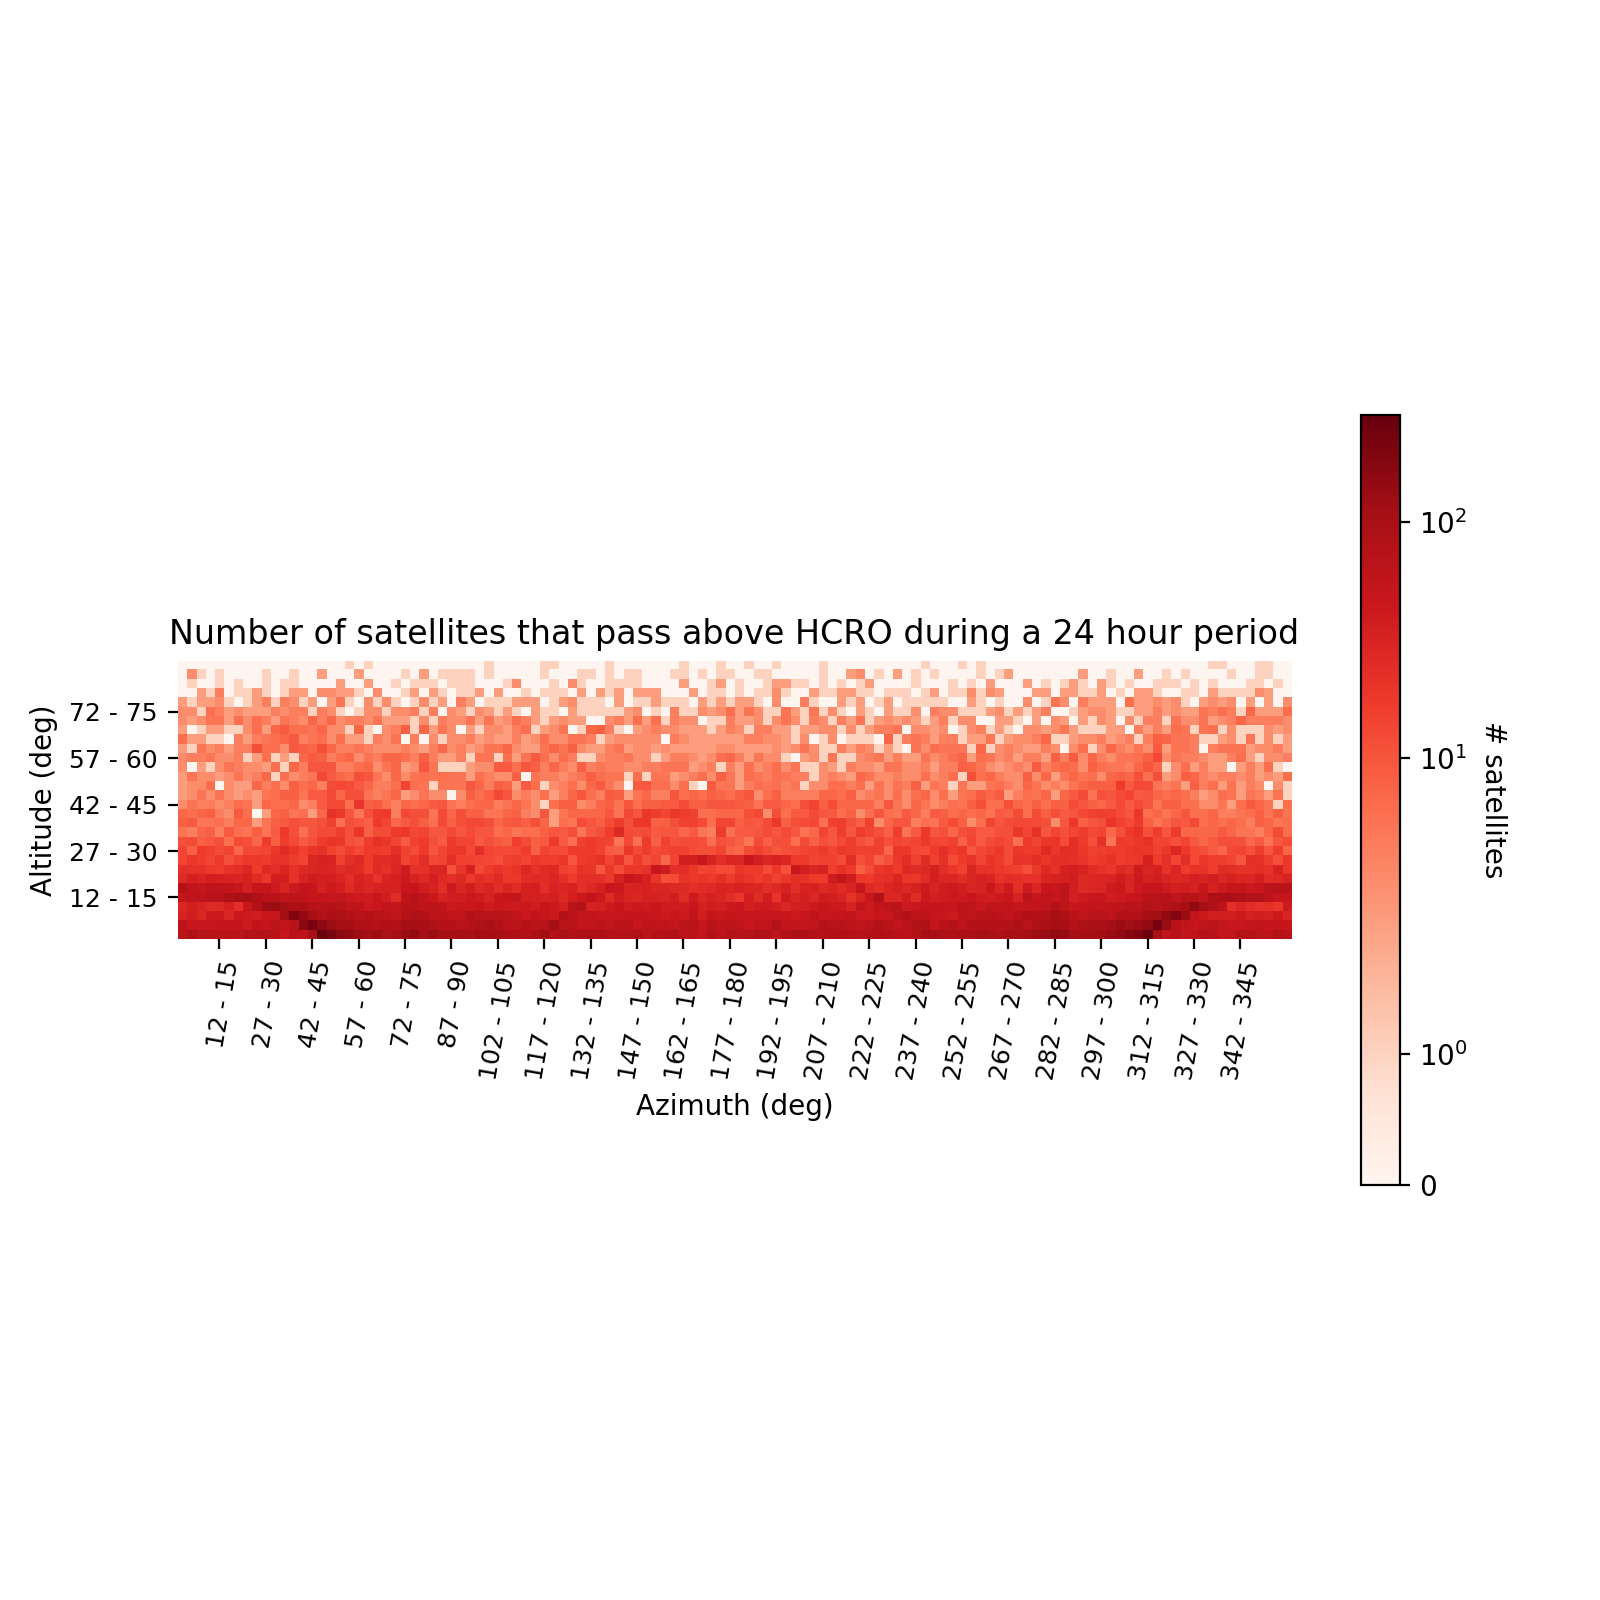

In [44]:
#with correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections3q), alt_range3f, az_range3f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs3, labels=az_range3f_label)
plt.yticks(ticks = alts3, labels = alt_range3f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
plt.savefig('3deg.jpeg')

<IPython.core.display.Javascript object>


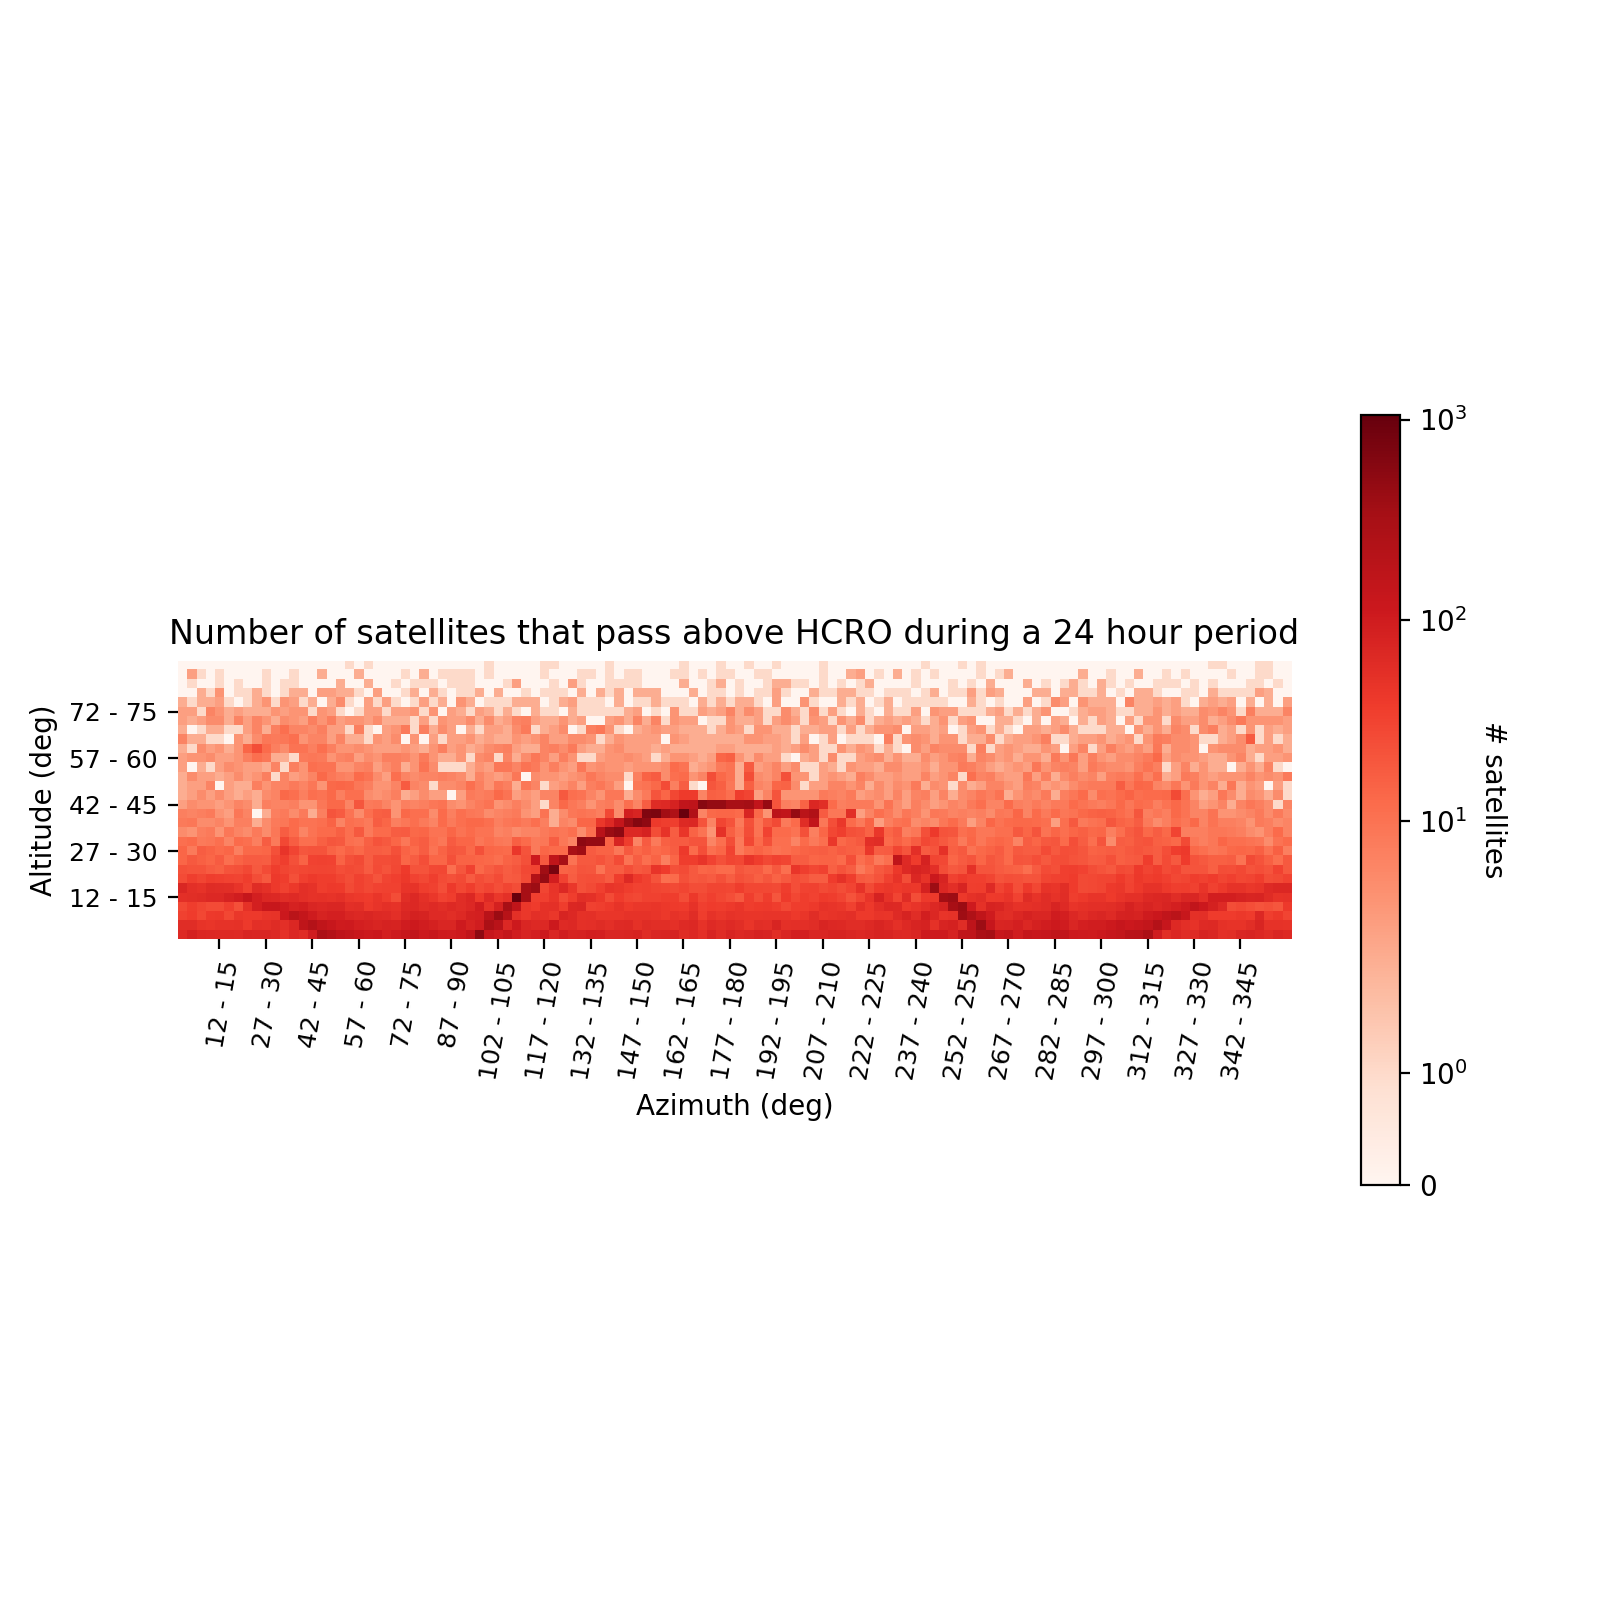

In [45]:
#without correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections3a), alt_range3f, az_range3f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs3, labels=az_range3f_label)
plt.yticks(ticks = alts3, labels = alt_range3f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('5deg.jpeg')

And then for the $90 \times 360$ grid

In [46]:
%%time
qt1 = []
at1 = []
for i in range(len(alt)):
    #print(i)
    for j in range(len(t)):
        if alt[i][j] > 0:
            for h in range(0, 90):
                if (h*1) <= alt[i][j] < ((h+1)*1):
                    for k in range(0, 360):
                        if (k*1) <= az[i][j] < ((k+1)*1):
                            qt1.append((h*360) + k + 1)
                            at1.append((h*360) + k + 1)
        if alt[i][j] <= 0:
            qt1.append(0)
            at1.append(0)
        #if type(altaz_rebinned[i][j]) == int:
         #   qt.append(0)
          #  at.append(0)

CPU times: user 8.58 s, sys: 170 ms, total: 8.75 s
Wall time: 8.52 s


In [47]:
qt1 = np.reshape(qt1, (len(active), len(t)))
at1 = np.reshape(at1, (len(active), len(t)))

In [48]:
for i in range(len(at1)):
    for j in range(len(at1[0])-1):
        if at1[i][j] == at1[i][j+1]:
            qt1[i][j+1] = 0

In [49]:
qt1 = np.reshape(qt1, (len(active) * len(t)))
at1 = np.reshape(at1, len(active) * len(t))

In [50]:
%%time
s1a = []
s1q = []
for i in range(len(at1)):
    s1a.append(f's{at1[i]}')
for i in range(len(qt1)):
    s1q.append(f's{qt1[i]}')


CPU times: user 472 ms, sys: 25.6 ms, total: 497 ms
Wall time: 505 ms


In [58]:
%%time
#About 21 minutes to run
#which section the satellite is in
sections_1a = []
sections_1q = []
for i in range(1, 32401):
    #print(i) #Uncomment this if you want to see how much it's run
    if s1a.count(f's{i}') == 0:
        sections_1a.append(0)
        #print(i) #You can uncomment out the print function if you want to keep track of how it's running
    if s1a.count(f's{i}') != 0:
        sections_1a.append(s1a.count(f's{i}'))
    if s1q.count(f's{i}') == 0:
        sections_1q.append(0)
    if s1q.count(f's{i}') != 0:
        sections_1q.append(s1q.count(f's{i}'))

CPU times: user 22min 14s, sys: 12.9 s, total: 22min 27s
Wall time: 22min 36s


In [52]:
%%time
alt_range1f = []
az_range1f = []

for i in range(0,90):
    alt_range1f.append(f'{i*1} - {(i+1)*1}')
for i in range(0, 360):
    az_range1f.append(f'{i*1} - {(i + 1)*1}')

CPU times: user 88 µs, sys: 7 µs, total: 95 µs
Wall time: 95.1 µs


In [53]:
az_range1f_label = []
alt_range1f_label = []
azs1 = []
alts1 = []
for i in range(1, int(len(az_range1f)/10)):
    azs1.append((i*10)-1)
    az_range1f_label.append(az_range1f[azs1[-1]])
    
for i in range(1, int(len(alt_range1f)/10)):
    alts1.append((i*10)-1)
    alt_range1f_label.append(alt_range1f[alts1[-1]])

In [59]:
sections1a = np.reshape(sections_1a, (90, 360))
sections1q = np.reshape(sections_1q, (90, 360))
#making it to where it's a 2d array to plot on the heatmap

<IPython.core.display.Javascript object>


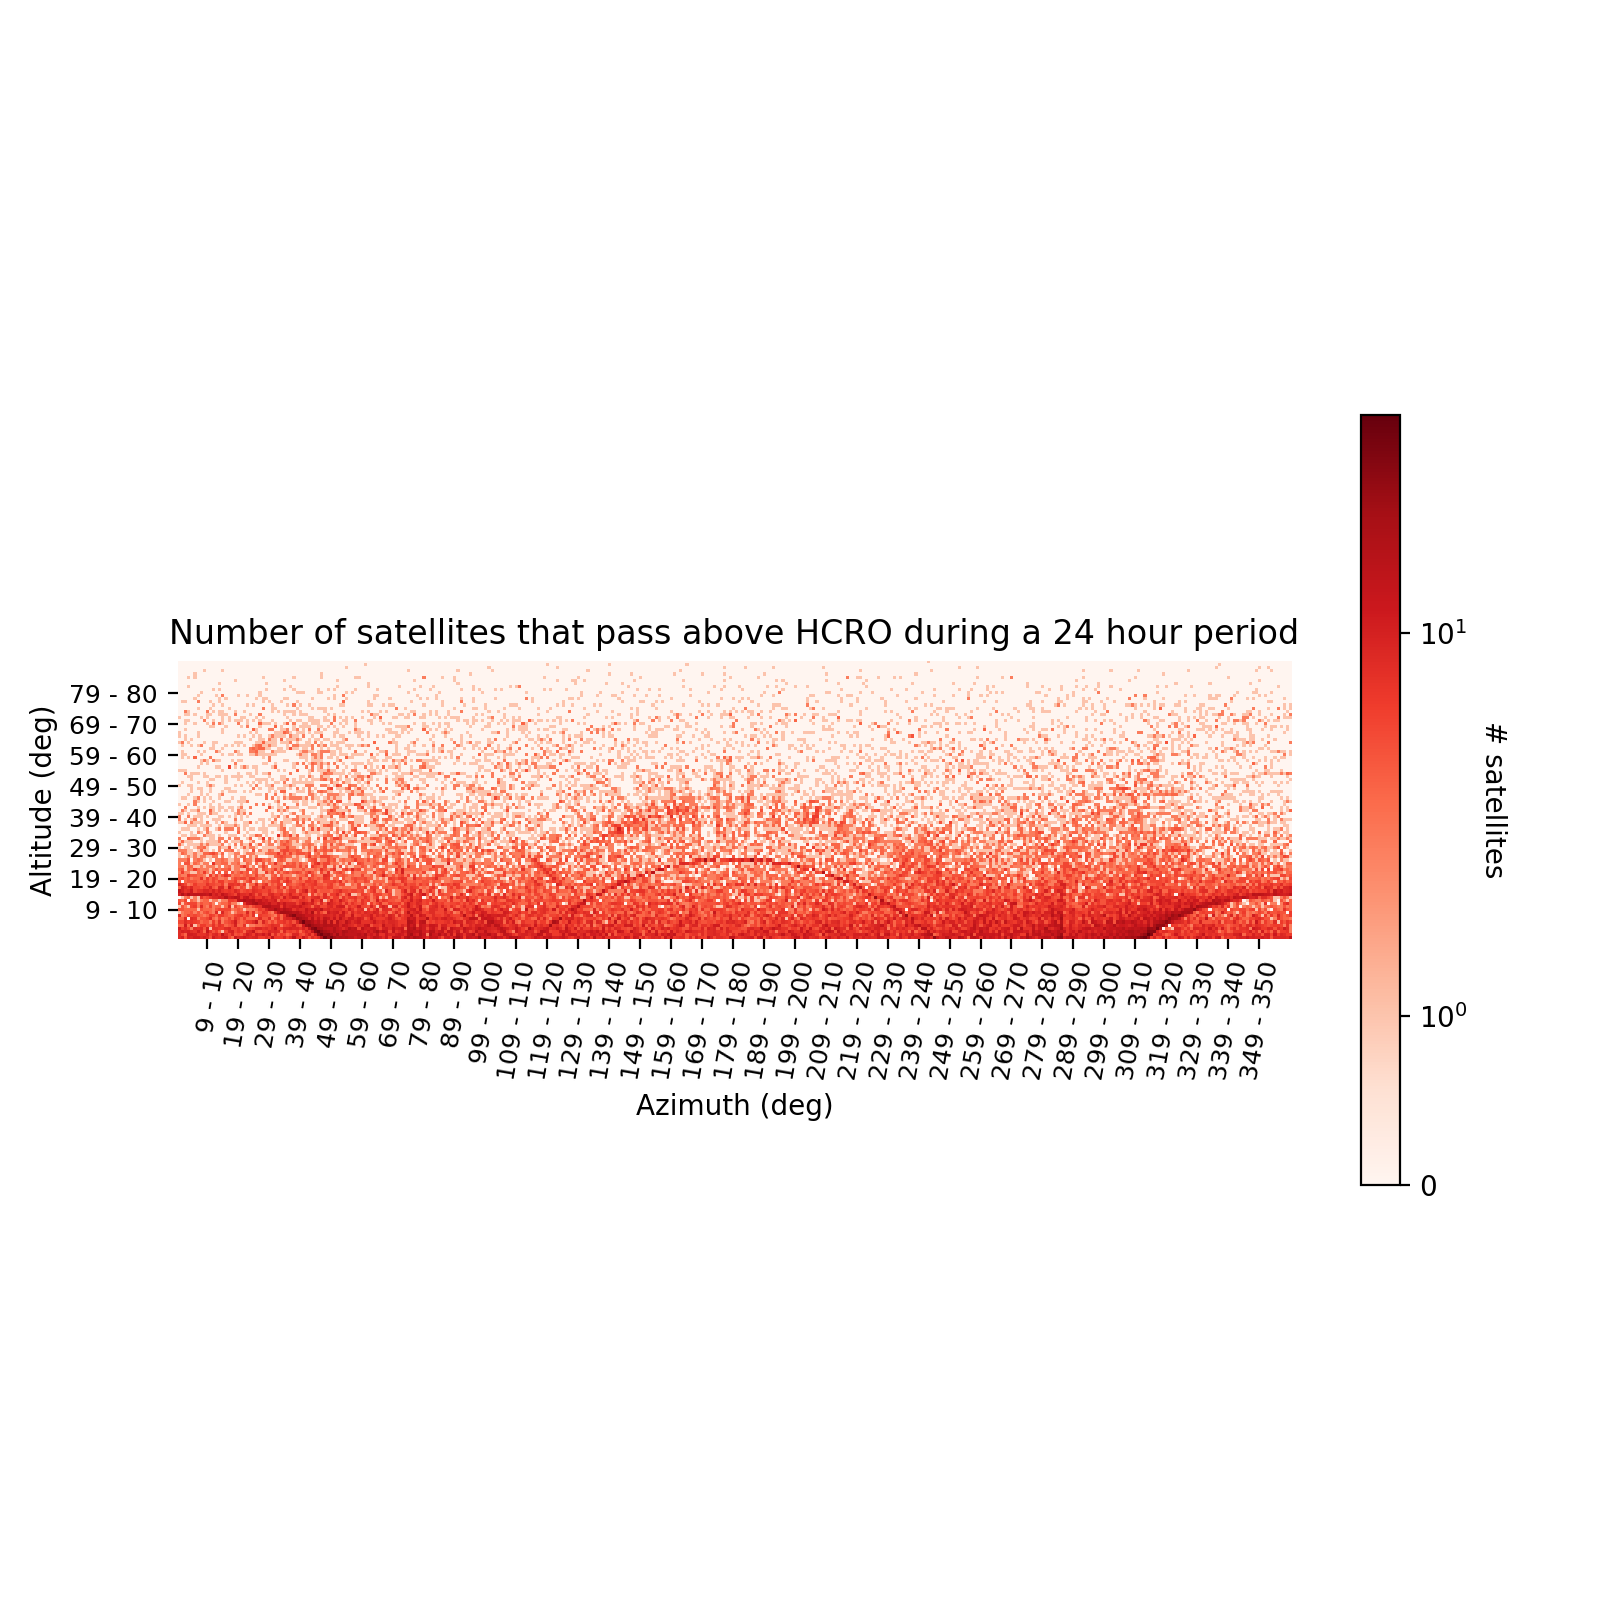

In [55]:
#with correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections1q), alt_range1f, az_range1f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs1, labels=az_range1f_label)
plt.yticks(ticks = alts1, labels = alt_range1f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
plt.savefig('1deg.jpeg')

<IPython.core.display.Javascript object>


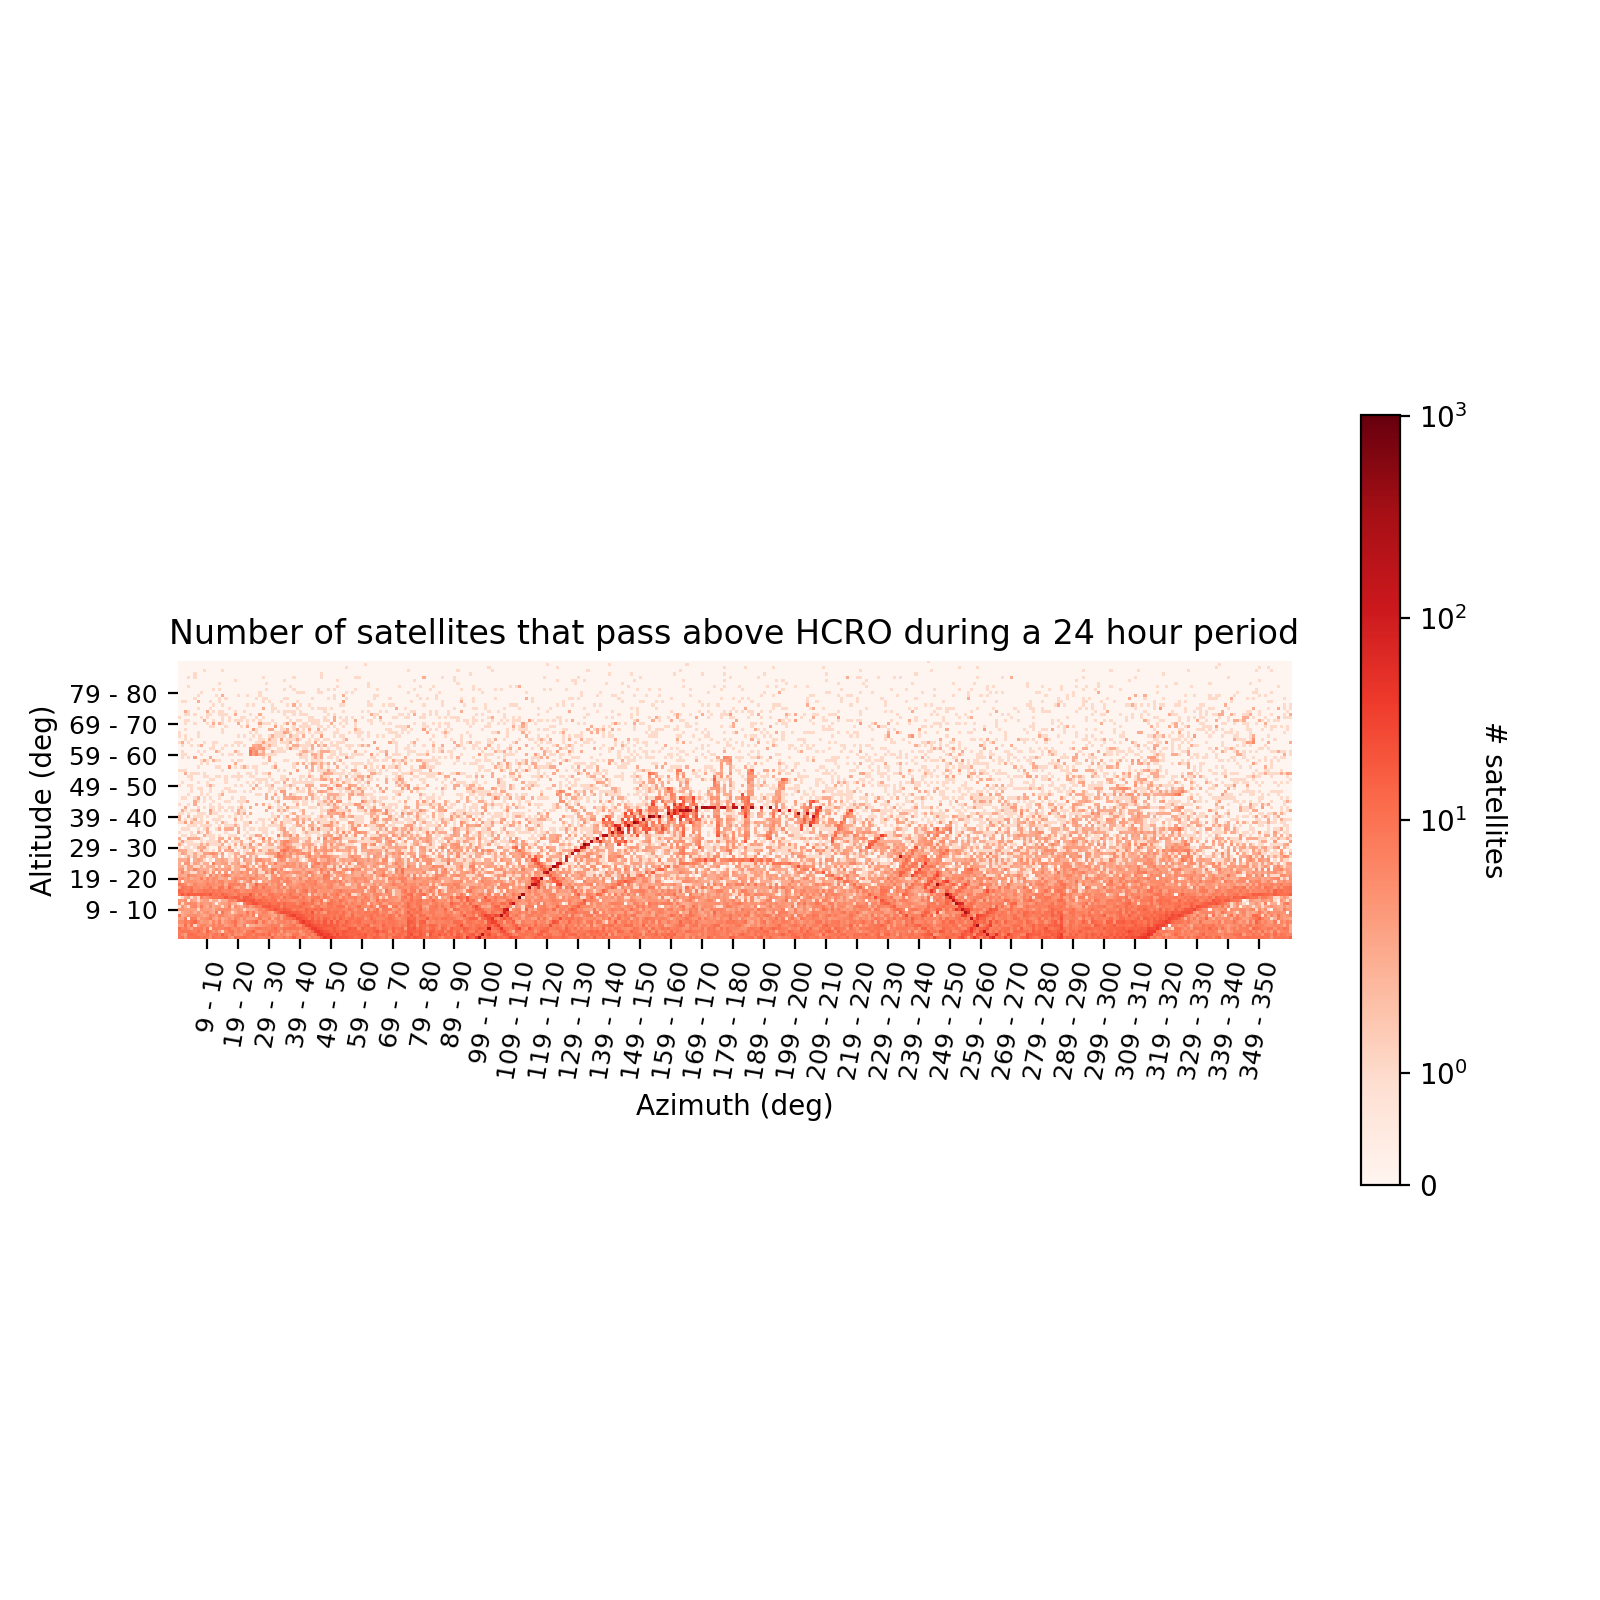

In [56]:
#without correcting for geo
fig, ax = plt.subplots(figsize = (8, 8))

im, cbar = heatmap(np.array(sections1a), alt_range1f, az_range1f, ax=ax,
                   cmap="Reds", cbarlabel="# satellites", norm = 'symlog')
#texts = annotate_heatmap(im, valfmt="{x:.0f}")
#uncomment out the line above if you want the text on the grids (sometimes hard to see)
plt.title('Number of satellites that pass above HCRO during a 24 hour period')
plt.xticks(ticks = azs1, labels=az_range1f_label)
plt.yticks(ticks = alts1, labels = alt_range1f_label)
plt.xlabel('Azimuth (deg)')
plt.ylabel('Altitude (deg)')
fig.tight_layout()
plt.show()
#plt.savefig('5deg.jpeg')